This is for learning and training perpose. 

Some resourced used: 
- https://github.com/nicknochnack/ImageClassification/blob/main/Getting%20Started.ipynb
- https://www.kaggle.com/code/muhammadfaizan65/knee-arthritis-detection-using-efficientnetb0/notebook
- data from https://github.com/LIamB12/health-app-backend/blob/main/app.py 

In [1]:
# Import required libraries
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, 
                                     Dropout, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0



2024-10-09 09:30:55.243488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 09:31:06.468170: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-09 09:31:06.468208: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-10-09 09:31:07.414805: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09 09:31:21.534935: W tensorflow/stream_executor/platform/de

Found 2060 files belonging to 2 classes.


2024-10-09 09:31:31.566741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-10-09 09:31:31.567580: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-10-09 09:31:31.567608: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-ec4b37): /proc/driver/nvidia/version does not exist
2024-10-09 09:31:31.611044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 09:31:37.278165: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 

Classes found: ['validate', 'train']


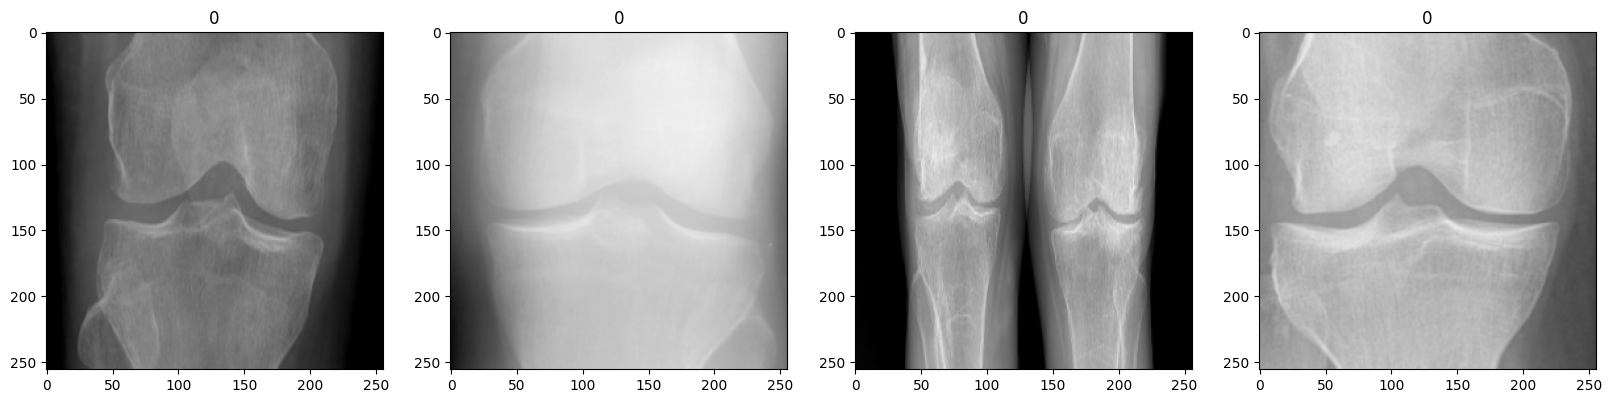

In [2]:
# load
data_dir = '/workspaces/ATAi_advance_notebooks/arthritis_data/all_images/'
data = tf.keras.utils.image_dataset_from_directory(data_dir)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

# display: 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# scale data: 
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

# Split data
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# classes: 
# Retrieve class names from the directory structure
class_names = os.listdir(data_dir)
num_classes = len(class_names)  # Should be 2 for your case
print(f"Classes found: {class_names}")



In [3]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

print("Shape of the batch images:", batch[0].shape)  # Should show the shape of images
print("Shape of the batch labels:", batch[1].shape)  # Should show the shape of labels


Shape of the batch images: (32, 256, 256, 3)
Shape of the batch labels: (32,)


In [4]:
model_set_up = "pretrained" # standard | healthapp | pretrained

if model_set_up == "standard" : 
    model = Sequential()

    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
    logdir='logs'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    hist = model.fit(train, steps_per_epoch=20, epochs=10, validation_data=val, callbacks=[tensorboard_callback])


elif model_set_up == "healthapp" : 
    # Define the model
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=RMSprop(learning_rate=0.01),  # Use `learning_rate` instead of `lr`
        metrics=['accuracy']
    )

    # Create a log directory for TensorBoard
    logdir = "logs"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

    # Fit the model with the TensorBoard callback
    hist = model.fit(
        train, 
        steps_per_epoch=40, 
        epochs=5,
        validation_data=val,
        callbacks=[tensorboard_callback]  # Add the callback here
    )

elif model_set_up == "pretrained":
    # Load the EfficientNetB0 model, excluding the top layers
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Unfreeze some layers of the base model
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Add new top layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Output for 2 classes
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model # original 
    # hist = model.fit(data, epochs=10)
    
    # Fit the model with the TensorBoard callback
    logdir='logs'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    hist = model.fit(
        train, 
        steps_per_epoch=40, 
        epochs=5,
        validation_data=val,
        callbacks=[tensorboard_callback]  # Add the callback here
    )

else: 
    print("no model")




NameError: name 'tensorboard_callback' is not defined

In [8]:
hist.

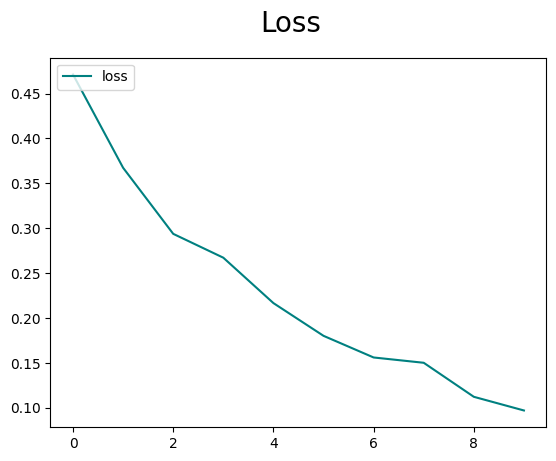

In [9]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
# plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

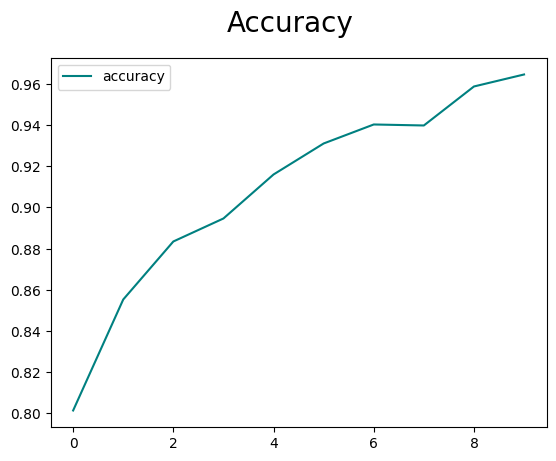

In [11]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
# plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [12]:
# Evaluate
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 2s 2s/step


ValueError: Shapes (32, 2) and (32,) are incompatible

In [21]:
print(pre.result(), re.result(), acc.result()) 


tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.7760417, shape=(), dtype=float32)


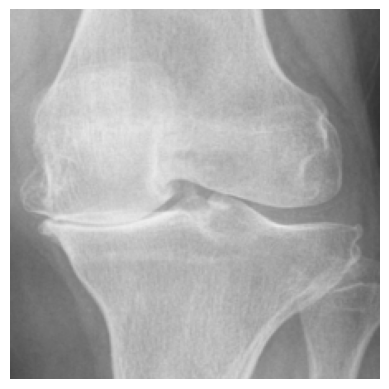

1/1 [==============================] - 1s 857ms/step
[[1. 0.]]
(1, 2)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the image and ensure it is in RGB format
# img_path = "/workspaces/ATAi_advance_notebooks/arthritis_data/notarthritis.jpg"
img_path = "/workspaces/ATAi_advance_notebooks/arthritis_data/itsarthritis.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Display the image
plt.imshow(img)
plt.axis('off')  # Optional: Turn off axis numbers and ticks
plt.show()

# Resize and normalize the image
resize = tf.image.resize(img, (256, 256)) / 255.0  # Resize and normalize in one line

# Expand dimensions to match model input shape
yhat = model.predict(np.expand_dims(resize, axis=0))  # Shape should be (1, 256, 256, 3)
print(yhat)

# Check shape of yhat to ensure it's a single output
print(yhat.shape)

# Classify based on prediction
if yhat > 0.5: 
    print(f'Predicted class is arthritis')
else:
    print(f'Predicted class is not arthritis')


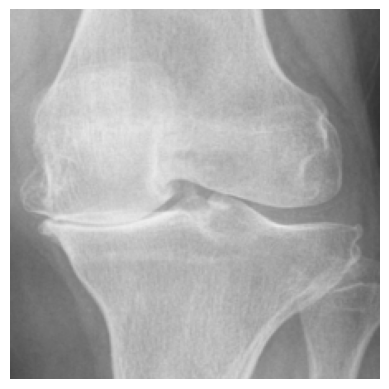

1/1 [==============================] - 0s 48ms/step


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the image and ensure it is in RGB format
img_path = "/workspaces/ATAi_advance_notebooks/arthritis_data/itsarthritis.jpg"
img = cv2.imread(img_path)

# Check if the image was loaded successfully
if img is None:
    print("Error: Image not found. Please check the file path.")
else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Optional: Turn off axis numbers and ticks
    plt.show()

    # Resize and normalize the image
    resize = tf.image.resize(img, (256, 256)) / 255.0  # Resize and normalize in one line

    # Expand dimensions to match model input shape
    yhat = model.predict(np.expand_dims(resize, axis=0))


In [18]:
yhat

array([[1., 0.]], dtype=float32)

In [ ]:
def predict_arthritis():
    # Get the image URL from the request

    img = tf.keras.preprocessing.image.load_img(BytesIO(response.content), target_size=(400, 400))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    img_array = img_array / 255.0  # Rescale the image

    # Make predictions
    predictions = arthritis_model.predict(img_array)

    # Interpret the predictions as probabilities
    probability = predictions[0][0]
    # Make predictions
    val = "unsure"
    percent = 0
    if probability > 0.5:
        val = "arthritis"
        percent = probability
    elif probability <= 0.5:
        val = "not arthritis"
        percent = 1 - probability
    # Return the predicted class and probability
    response = {
        'class_index': str(val),
        'probability': str(percent)
    }

    return jsonify(response)
